# Schrödinger Bridge Scheme for Minimizing Entropy


In this notebook, we approximate the explicit Euler discretization of the heat flow using our Schrödinger bridge (SB) scheme. Starting from a Gaussian distribution, where the true heat flow is analytically known, we perform and compare the SB steps for the continuous distribution. This notebook covers the following comparisons:

**Comparison of Analytical and Sample Approximations**:
We compare the analytically known gradient flow to the sample approximations of SB steps obtained by pushing forward the finite particles through transformations described in our [paper](https://arxiv.org/abs/2406.10823).

**Comparison of Schrödinger Bridge Approximation Methods**:
We evaluate the performance of two different methods for approximating the Schrödinger bridge, which is essential for obtaining the sample approximations of the SB steps.

In [75]:
import numpy as np
import os
from scipy.special import expit
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
from estimate_SB import _gibbs_one_iter, schbridge, sinkhorn, cost_matrix
from matplotlib.animation import FuncAnimation
import time

In [76]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Suppose I have $X := (x_1, \dots, x_n)$ observed from $\rho_0$. The empirical starting measure is $\rho_n(x) = n^{-1}I(x \in X)$. 
Recall that the SB scheme with the starting measure $\rho$ is
$$\rho_\epsilon^* = (2Id -  E_{\pi_{\epsilon, \rho}}[Y | X = .])_\# \rho$$
Now the SB scheme strating from $\rho_n$ is 
$$x_i \mapsto 2x_i - E_{\pi_{\epsilon, \rho_n}}[Y | X = x_i].$$
First, we approximate the discrete Schrödinger bridge $\pi_{\epsilon, \rho_n}$ using Sinkhorn algorithm, denoted by $\hat{\pi}_{\epsilon, \rho_n} \in [0,1]^{n \times n}$. Second, the conditional expectation $E_{\pi_{\epsilon, \rho_n}}[Y | X = .]$ is approximated by its empirical version. Therefore,
\begin{align*}
E_{\hat{\pi}_{\epsilon, \rho_n}}[Y|X=x_i] &= \frac{\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}}{\rho_n(x_i)}
&=  n\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}\\
\end{align*}

Finally, we have the sample approxiation of the SB step as
$$x_i \mapsto 2x_i- n\sum_{j=1}^n x_j \hat{\pi}_{\epsilon, \rho_n}^{ij}$$
We used both -- the celebrated Sinkhorn algorithm [(Peyré, G. and Cuturi, M. (2019)., Section 4.2)](https://www.nowpublishers.com/article/Details/MAL-073) and the MCMC method from [Harchaoui et. al (2020)](https://projecteuclid.org/journals/bernoulli/volume-30/issue-3/Asymptotics-of-discrete-Schr%c3%b6dinger-bridges-via-chaos-decomposition/10.3150/23-BEJ1659.full).

In [77]:
# helper functions for making plots and calculating deterministic variances

def draw_gaussian(mean, std_dev):
    # Generate data points for the x-axis
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)

    # Compute the probability density function (PDF) for each data point
    pdf_values = norm.pdf(x, mean, std_dev)

    return x, pdf_values

def forward_SB_var(sigma_squared, eps, k=1):

    new_sigma_squared = ((2 - (sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2)))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    elif k==0:
        return sigma_squared
    else:
        return forward_SB_var(new_sigma_squared, eps, k=k-1)

def reverse_SB_var(sigma_squared, eps, k=1):

    new_sigma_squared = ((sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    elif k==0:
        return sigma_squared
    else:
        return reverse_SB_var(new_sigma_squared, eps, k=k-1)

def draw_gaussian_mix(mu1=-2, mu2=2, std_dev=1):
    # Generate data points for the x-axis

    x = np.linspace(mu1 - 3*std_dev, mu2 + 3*std_dev, 1000)
    # Compute the probability density function (PDF) for each data point
    pdf_values = 0.5*norm.pdf(x, mu1, std_dev) + 0.5*norm.pdf(x, mu2, std_dev)

    return x, pdf_values


In [78]:
def update_plot(frame, SB_steps, steps, eps, sigma_squared, forward, xlim, ylim):
    cmap = plt.get_cmap("gist_heat")
    color = cmap((frame)/len(steps))

    plt.clf()  # Clear the previous plot (if any)
    
    # Your plotting logic for each frame
    step = steps[frame]
    plt.hist(SB_steps[frame], density=True, bins=15, color=color, edgecolor='white')
    plt.title(f'Time: {np.round(eps*step, 1)}')
    plt.xlim(-xlim, xlim)
    plt.ylim(0, ylim)

    if forward:
        true_var = sigma_squared + step*eps
        SB_var = forward_SB_var(sigma_squared, eps, k=step)
    else:
        true_var = sigma_squared - step*eps
        SB_var = reverse_SB_var(sigma_squared, eps, k=step)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    plt.plot(x, pdf_values, label=r'$\rho_t$', color='indigo', linewidth=5)
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    plt.plot(x, pdf_values, label=r'$\hat \rho_t$', color='aqua', linewidth=2, linestyle='--')
    plt.legend()

In [79]:
def update_plot_gauss_mix(frame, SB_steps, steps, eps, mu1, mu2, sigma_squared, forward, xlim, ylim):

    cmap = plt.get_cmap("gist_heat")
    color = cmap((frame)/len(steps))
    
    plt.clf()  # Clear the previous plot (if any)
    
    # Your plotting logic for each frame
    step = steps[frame]
    plt.hist(SB_steps[frame], density=True, bins=15, color=color, edgecolor='white')
    plt.title(f'Time: {np.round(eps*step, 1)}')
    plt.xlim(-xlim, xlim)
    plt.ylim(0, ylim)
    
    if forward:
        true_var = sigma_squared + step*eps
        SB_var = forward_SB_var(sigma_squared, eps, k=step)
    else:
        true_var = sigma_squared - step*eps
        SB_var = reverse_SB_var(sigma_squared, eps, k=step)
    
    x, pdf_values = draw_gaussian_mix(mu1, mu2, std_dev=np.sqrt(true_var))
    plt.plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=4)
    x, pdf_values = draw_gaussian_mix(mu1, mu2, std_dev=np.sqrt(SB_var))
    plt.plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=2)
    plt.legend()


Now we plot the histogram of particles at increments of one second going through the dynamic of SB scheme for minimizing the entropy functional. 

### Example 1: Starting with standard Gaussian distribution

#### Sinkhorn, $\epsilon = 0.1$

In [80]:
# starting distribution
source_dist = 'gaussian'
direction = 'forward'
mean, sigma, sigma_squared = 0, 1, 1

# SB scheme hyperparameters
step_size = 0.1
total_time = 5
SB_estimation_method = 'sinkhorn'
max_steps = int(total_time/step_size)
all_steps = 10*np.arange((max_steps//10)+1)
dir = f'results/{SB_estimation_method}/{source_dist}/{direction}'

# load the SB steps
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)

Step: 0, idx: 0, true var: 1.0, SB_var: 1
Step: 10, idx: 1, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 2, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 3, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 4, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 5, true var: 6.0, SB_var: 5.998912115935248


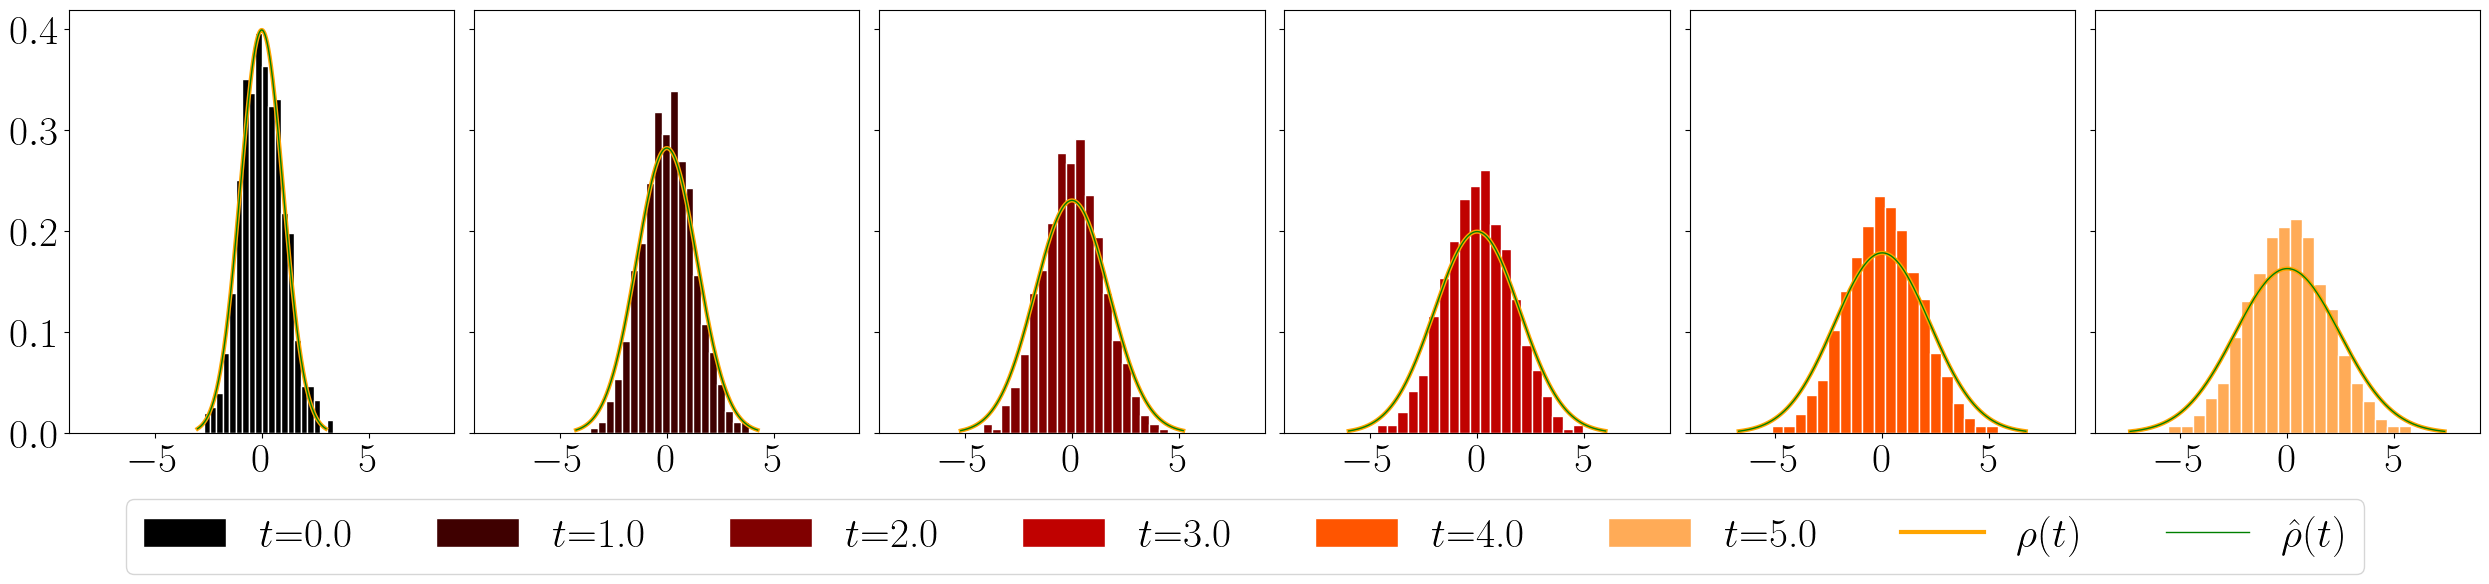

In [81]:
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)
plot_steps = [0, 10, 20, 30, 40, 50]

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 ,:], color=color, edgecolor='white', bins=20, density=True, label=f'$t$={time}')
    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))

    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho(t)$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho(t)$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)        
    axs[i].set_xlim(-xlim, xlim)

plt.tight_layout()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.savefig(os.path.join(dir, f'eps{step_size}_time{time}.png'))
plt.show()



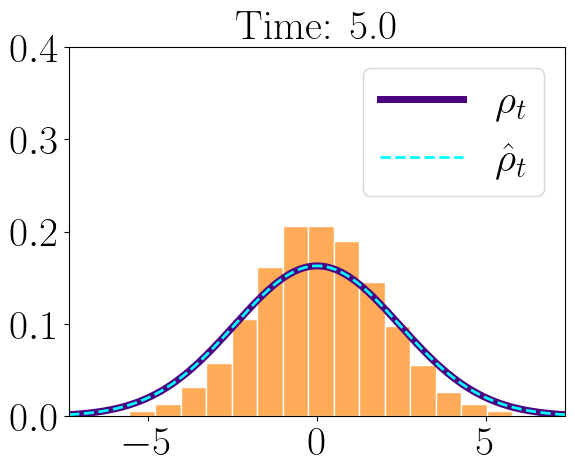

In [82]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots()

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.4), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


#### MCMC, $\epsilon = 0.1$

In [83]:
# SB scheme hyperparameters
SB_estimation_method = 'mcmc'
step_size = 0.1
max_steps = int(total_time/step_size)
all_steps = 10*np.arange(1, (max_steps//10)+1)

# load the SB steps
dir = f'results/{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)

Step: 10, idx: 0, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 1, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 2, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 3, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 4, true var: 6.0, SB_var: 5.998912115935248


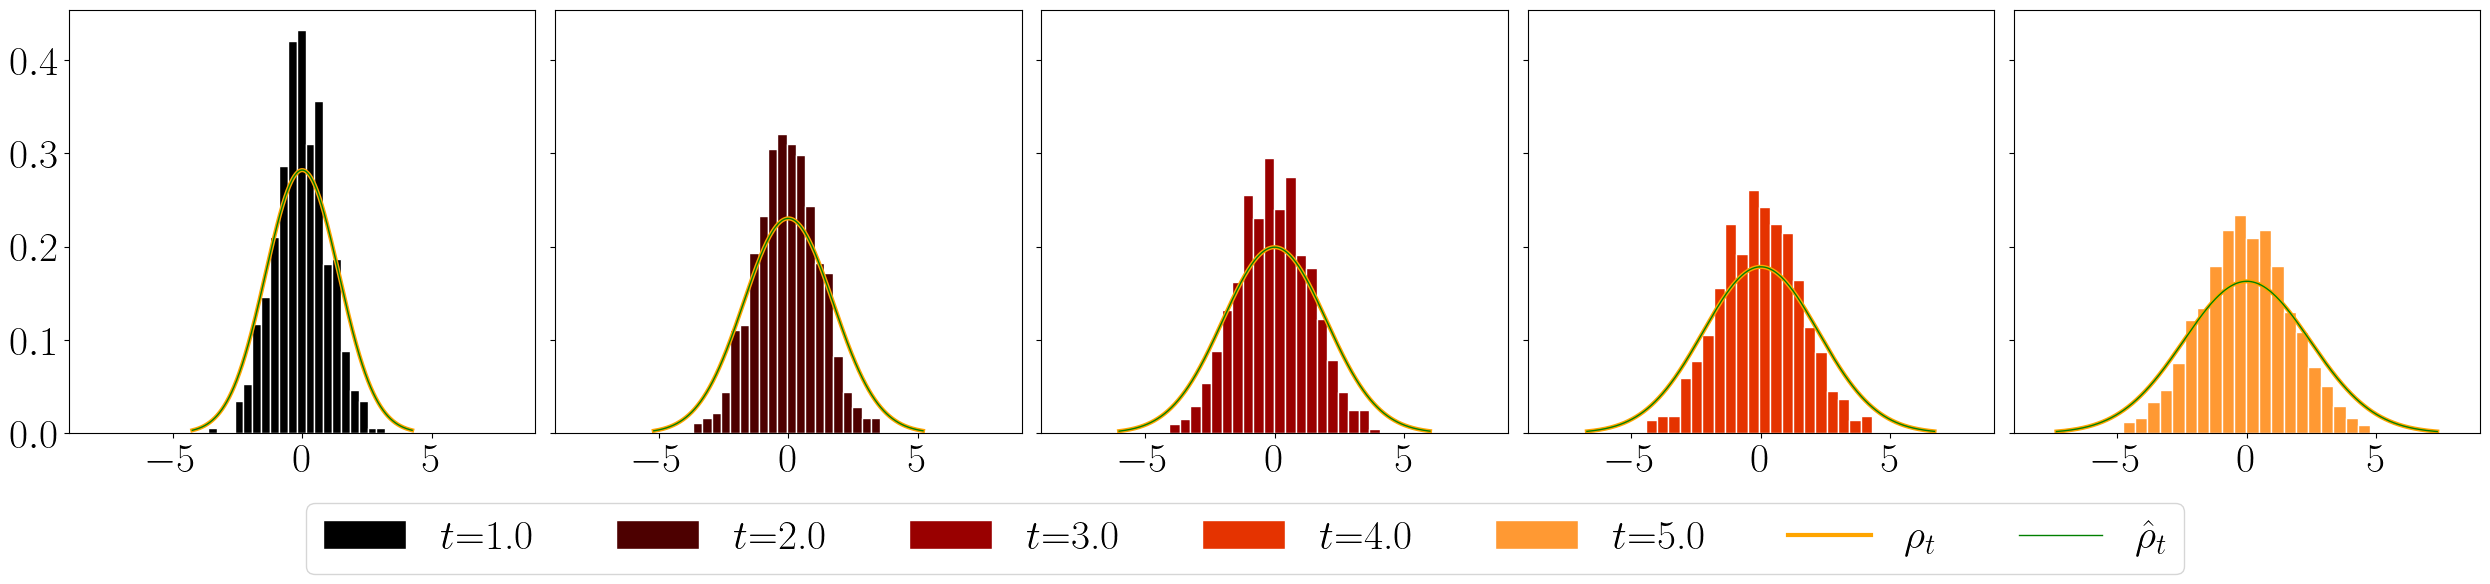

In [84]:
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 5, figsize=(25,5), sharey=True)
plot_steps = np.array(np.arange(1, total_time+1)/step_size, dtype=int)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10-1 ,:], color=color, edgecolor='white', bins=20, density=True, label=f'$t$={time}')
    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10-1}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='orange', linewidth=3)
    else:
        axs[i].plot(x, pdf_values, color='orange', linewidth=3)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='green', linewidth=1)
    else:
        axs[i].plot(x, pdf_values, color='green', linewidth=1)

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.show()

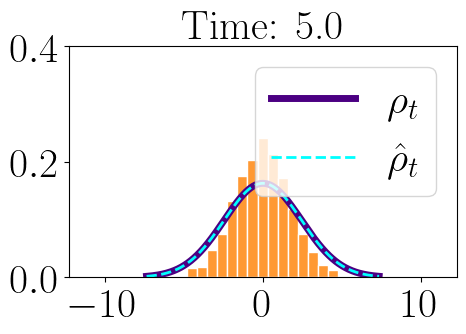

In [85]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots(figsize = (5,3))

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 5*np.sqrt(sigma_squared + total_time), 0.4), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


### Example 2: Starting with a mixture of Gaussian distributions

#### Sinkhorn, $\epsilon = 0.1$

[]

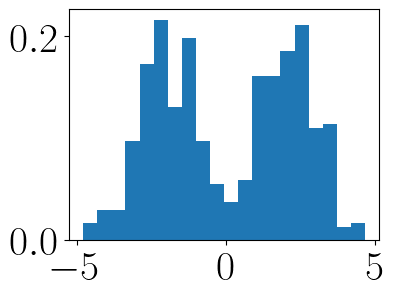

In [102]:
mu1, mu2 = -2, 2
sigma_squared = 1
X = np.concatenate((np.random.normal(mu1, 1, 500//2), np.random.normal(mu2, 1, 500//2)))
fig = plt.figure(figsize= (4,3))
plt.hist(X, density = True, bins=20)
plt.plot()

In [103]:
# starting distribution
source_dist = 'gaussian_mix'
direction = 'forward'
mu1, mu2 = -2, 2

# SB scheme hyperparameters
SB_estimation_method = 'sinkhorn'
step_size = 0.1
total_time = 5
max_steps = int(total_time/step_size)
all_steps = 10*np.arange((max_steps//10)+1)
plot_steps = np.array(np.arange(6)/step_size, dtype=int)

# load SB steps
dir = f'results/{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)

Step: 0, idx: 0, true var: 1.0, SB_var: 1
Step: 10, idx: 1, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 2, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 3, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 4, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 5, true var: 6.0, SB_var: 5.998912115935248


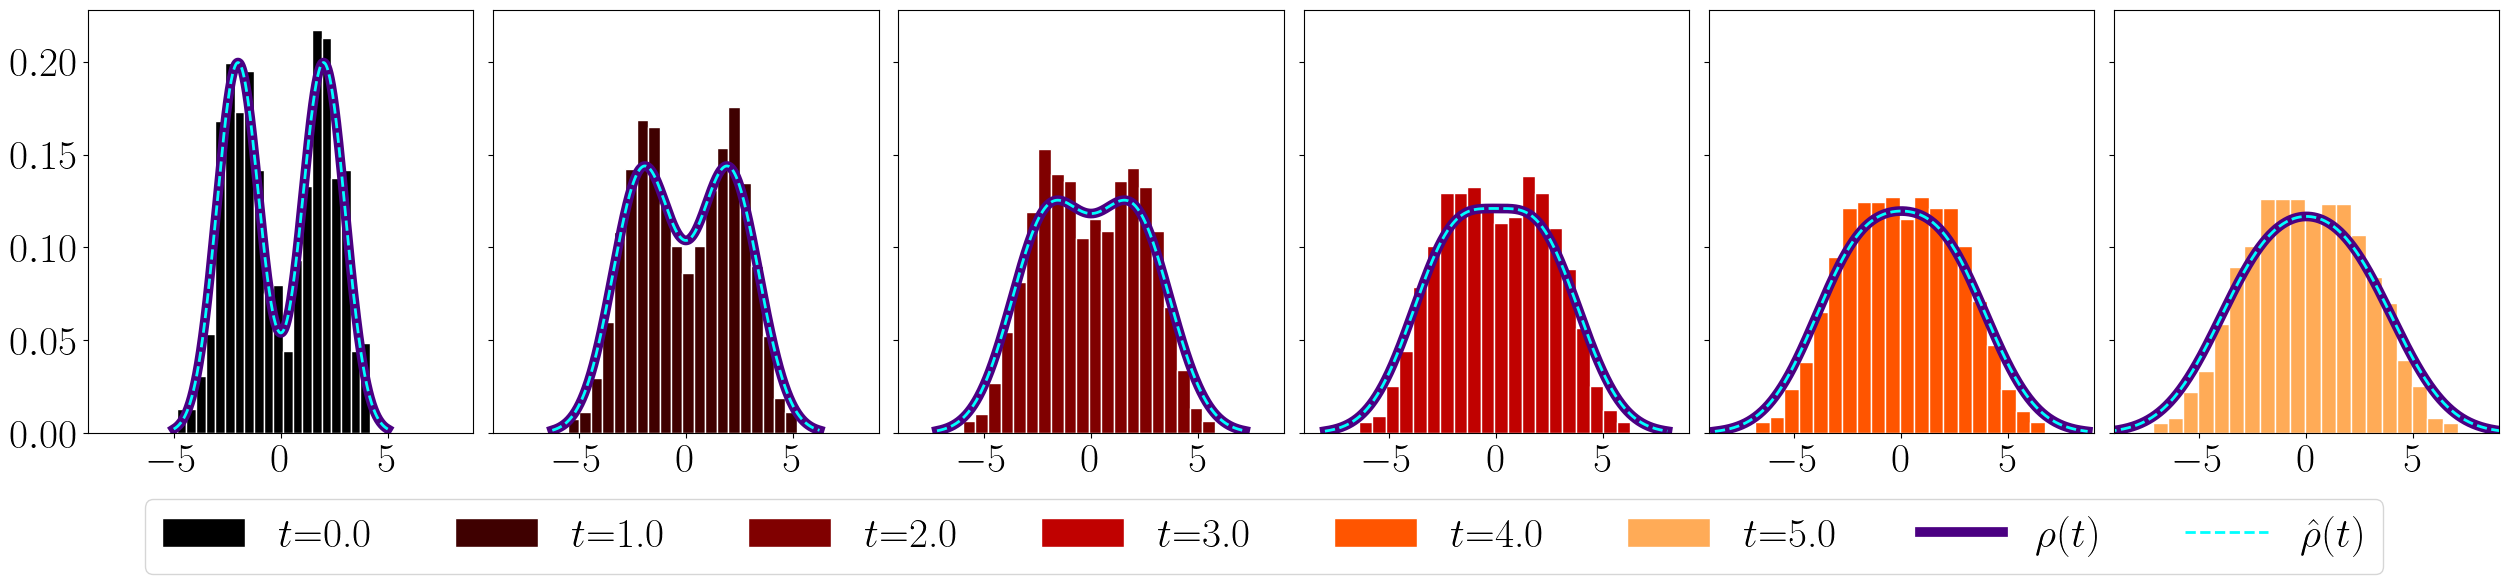

In [104]:
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 ,:], color=color, edgecolor='white', bins=20, density=True, label=f'$t$={time}')

    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho(t)$', color='indigo', linewidth=7)
    else:
        axs[i].plot(x, pdf_values, color='indigo', linewidth=7)

    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho(t)$', color='aqua', linewidth=2, linestyle='--')
    else:
        axs[i].plot(x, pdf_values, color='aqua', linewidth=2, linestyle='--')

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.savefig(os.path.join(dir, f'eps{step_size}_time{time}.png'))
plt.show()

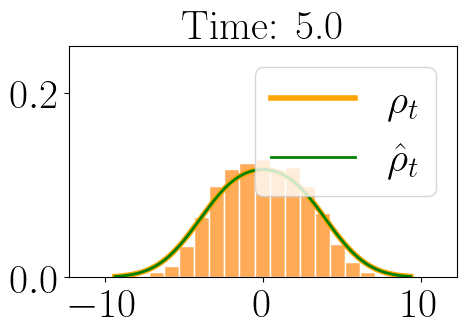

In [105]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots(figsize = (5,3))

# Create the animation
animation = FuncAnimation(fig, update_plot_gauss_mix, frames=num_frames, fargs=(X_SB, all_steps, step_size, mu1, mu2, sigma_squared, True, 5*np.sqrt(sigma_squared + total_time), 0.25), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


#### MCMC, $\epsilon = 0.1$

In [111]:
# SB scheme hyperparameters
SB_estimation_method = 'mcmc'
direction = 'forward'
total_time = 5
step_size = 0.1
max_steps = int(total_time/step_size)
plot_steps = np.array(np.arange(6)/step_size, dtype=int)

# load SB steps
dir = f'results/{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)

Step: 0, idx: 0, true var: 1.0, SB_var: 1
Step: 10, idx: 1, true var: 2.0, SB_var: 1.9993394637211244
Step: 20, idx: 2, true var: 3.0, SB_var: 2.999124466238449
Step: 30, idx: 3, true var: 4.0, SB_var: 3.9990179584482197
Step: 40, idx: 4, true var: 5.0, SB_var: 4.99895437290321
Step: 50, idx: 5, true var: 6.0, SB_var: 5.998912115935248


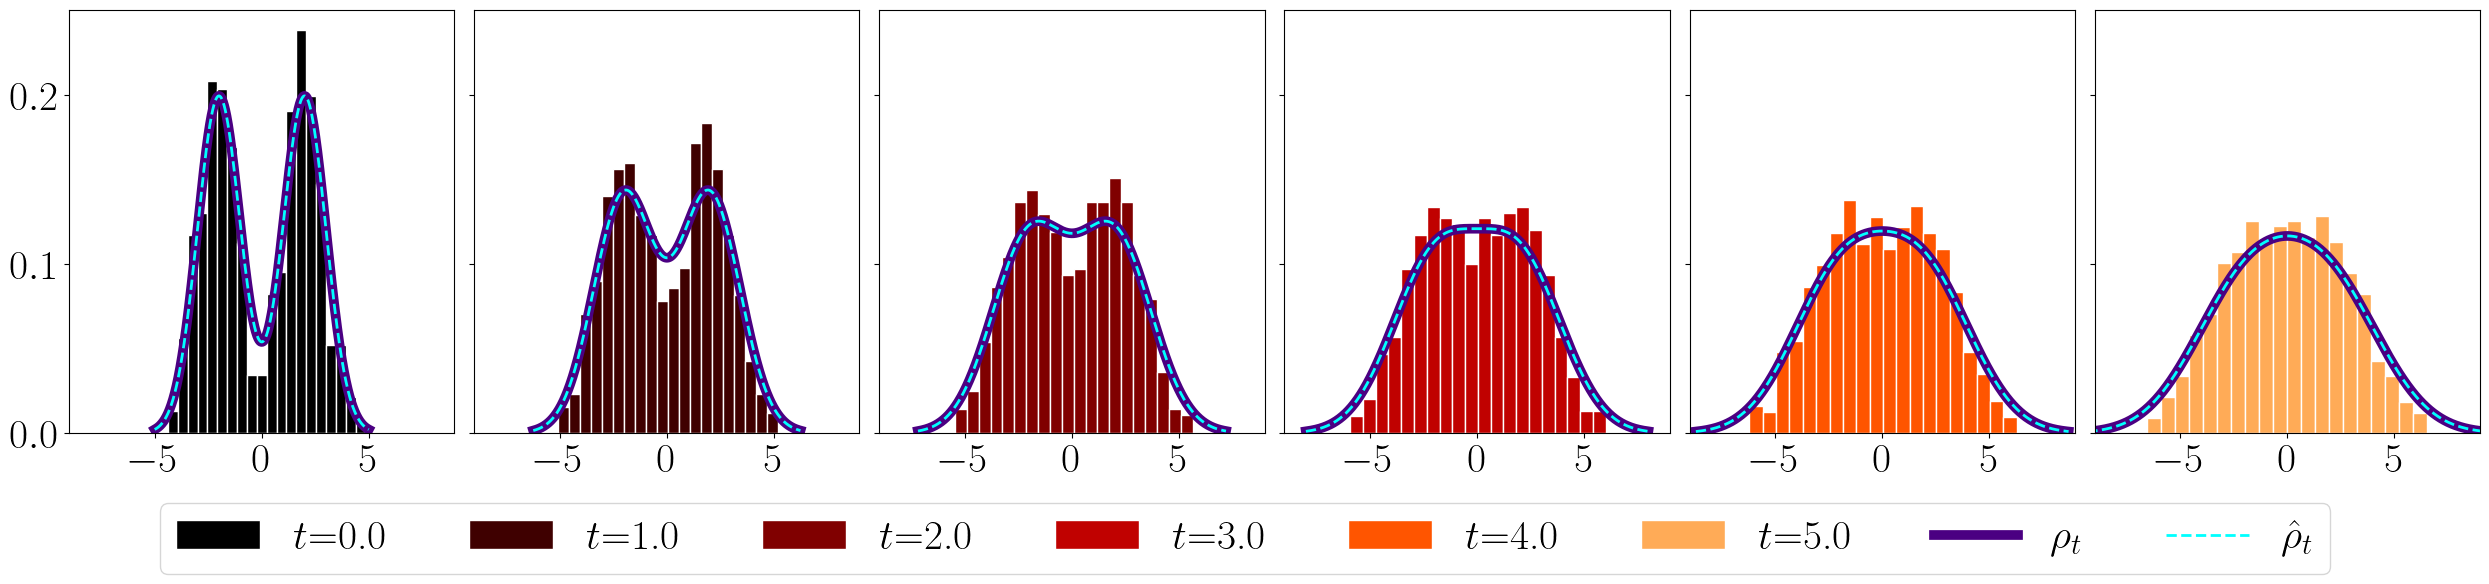

In [113]:
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10 ,:], color=color, edgecolor='white', bins=20, density=True, label=f'$t$={time}')

    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='indigo', linewidth=7)
    else:
        axs[i].plot(x, pdf_values, color='indigo', linewidth=7)

    x, pdf_values = draw_gaussian_mix(mu1=mu1, mu2=mu2, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='aqua', linewidth=2, linestyle='--')
    else:
        axs[i].plot(x, pdf_values, color='aqua', linewidth=2, linestyle='--')

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.show()

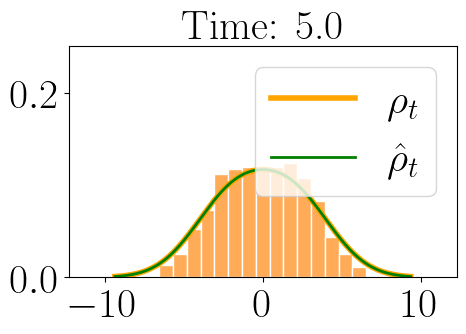

In [108]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots(figsize = (5,3))

# Create the animation
animation = FuncAnimation(fig, update_plot_gauss_mix, frames=num_frames, fargs=(X_SB, all_steps, step_size, mu1, mu2, sigma_squared, True, 5*np.sqrt(sigma_squared + total_time), 0.25), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


### Example 3: Starting from thin Gaussian

#### Sinkhorn, $\epsilon = 0.1$

In [114]:
# starting distribution
SB_estimation_method = 'sinkhorn'
source_dist = 'thin_gaussian'
mu, sigma_squared, sigma = 0, .25, .5

# SB scheme hyperparameters
direction = 'forward'
total_time = 5
step_size = 0.1
max_steps = int(total_time/step_size)
all_steps = 10*np.arange((max_steps//10)+1)
plot_steps = np.array(np.arange(6)/step_size, dtype=int)

# load SB steps
dir = f'results/{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)

Step: 0, idx: 0, true var: 0.25, SB_var: 0.25
Step: 10, idx: 1, true var: 1.25, SB_var: 1.2452624616415275
Step: 20, idx: 2, true var: 2.25, SB_var: 2.2447942744790277
Step: 30, idx: 3, true var: 3.25, SB_var: 3.2446177909007297
Step: 40, idx: 4, true var: 4.25, SB_var: 4.244525171659953
Step: 50, idx: 5, true var: 5.25, SB_var: 5.244468118797837


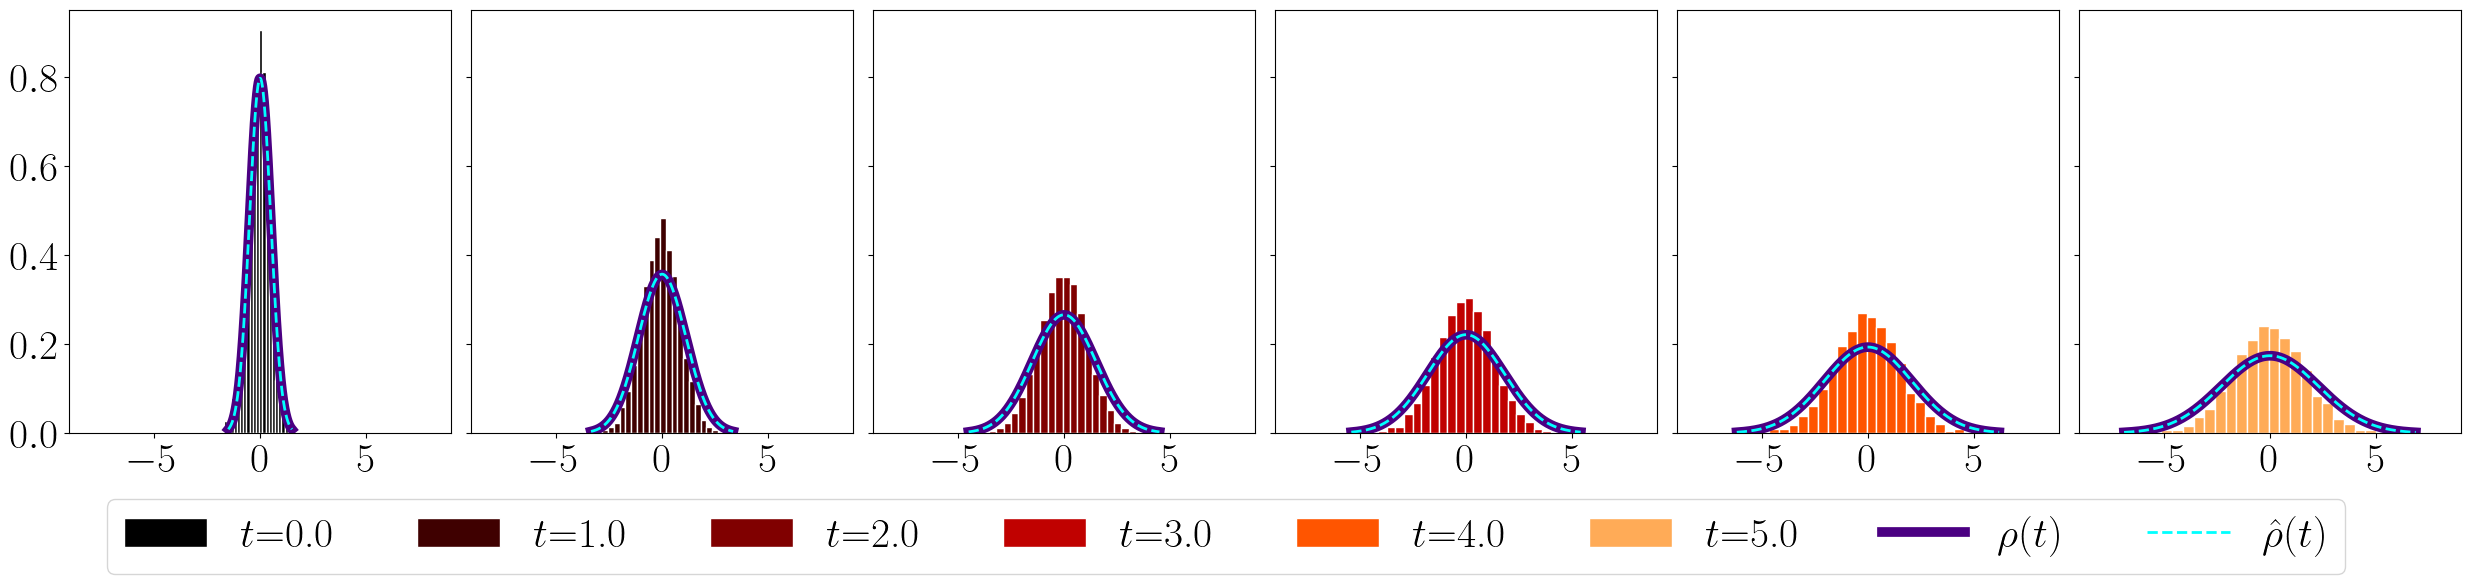

In [115]:
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,5), sharey=True)


for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10,:], color=color, edgecolor='white', bins=20, density=True, label=f'$t$={time}')

    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mu, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho(t)$', color='indigo', linewidth=7)
    else:
        axs[i].plot(x, pdf_values, color='indigo', linewidth=7)

    x, pdf_values = draw_gaussian(mu, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho(t)$', color='aqua', linewidth=2, linestyle='--')
    else:
        axs[i].plot(x, pdf_values, color='aqua', linewidth=2, linestyle='--')

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2)
plt.tight_layout()
plt.savefig(os.path.join(dir, f'eps{step_size}_time{time}.png'))
plt.show()

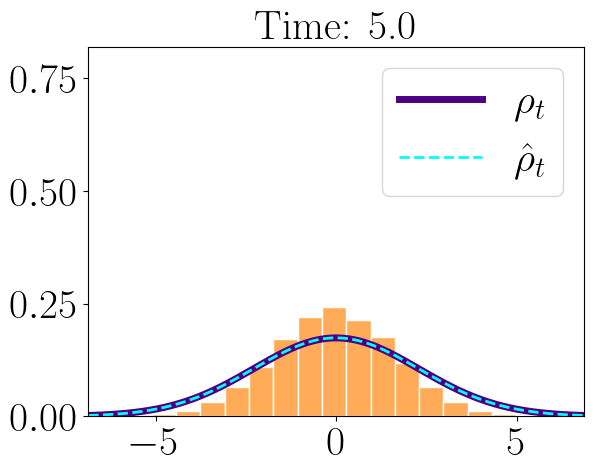

In [116]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots()

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.82), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()


#### MCMC, $\epsilon = 0.1$

In [117]:
# SB scheme hyperparameters
step_size = 0.01
max_steps = int(total_time/step_size)
plot_steps = np.array(np.arange(6)/step_size, dtype=int)

# load SB steps
dir = f'results/{SB_estimation_method}/{source_dist}/{direction}'
file_path = os.path.join(dir, f'eps{step_size}_time{total_time}.npy')
X_SB = np.load(file_path)
X_SB.shape

(51, 500)

Step: 0, idx: 0, true var: 0.25, SB_var: 0.25
Step: 100, idx: 10, true var: 1.25, SB_var: 1.249959275599876
Step: 200, idx: 20, true var: 2.25, SB_var: 2.249954810166051
Step: 300, idx: 30, true var: 3.25, SB_var: 3.2499530958820797
Step: 400, idx: 40, true var: 4.25, SB_var: 4.249952189038239
Step: 500, idx: 50, true var: 5.25, SB_var: 5.249951627908027


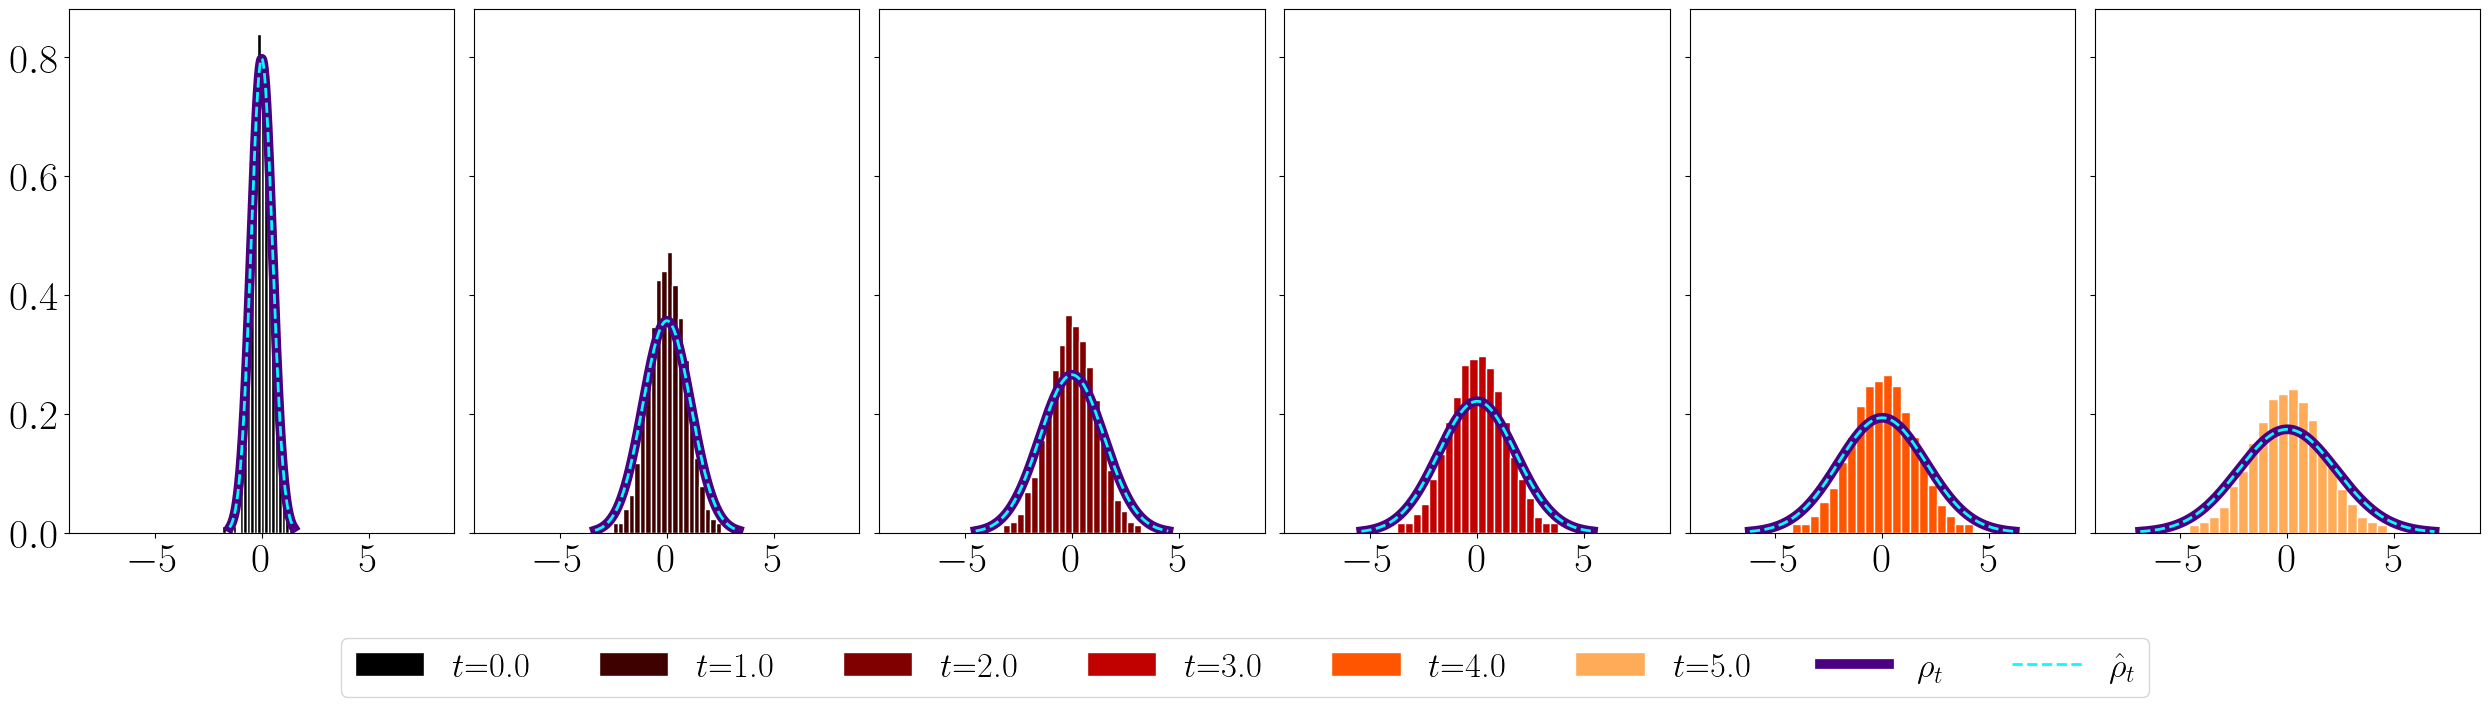

In [118]:
cmap = plt.get_cmap("gist_heat")
fig, axs = plt.subplots(1, 6, figsize=(25,6), sharey=True)

for i in range(len(plot_steps)):
    step = plot_steps[i]
    time = step*step_size
    xlim = 9
    color = cmap(i/len(plot_steps))

    axs[i].hist(X_SB[plot_steps[i]//10,:], color=color, edgecolor='white', bins=20, density=True, label=f'$t$={time}')

    true_var = sigma_squared + time
    SB_var = forward_SB_var(sigma_squared, step_size, k=step)
    print(f'Step: {step}, idx: {plot_steps[i]//10}, true var: {true_var}, SB_var: {SB_var}')
    x, pdf_values = draw_gaussian(mu, std_dev=np.sqrt(true_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\rho_t$', color='indigo', linewidth=7)
    else:
        axs[i].plot(x, pdf_values, color='indigo', linewidth=7)

    x, pdf_values = draw_gaussian(mu, std_dev=np.sqrt(SB_var))
    if i == len(plot_steps)-1:
        axs[i].plot(x, pdf_values, label=r'$\hat \rho_t$', color='aqua', linewidth=2, linestyle='--')
    else:
        axs[i].plot(x, pdf_values, color='aqua', linewidth=2, linestyle='--')

        
    axs[i].set_xlim(-xlim, xlim)
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=len(plot_steps)+2, fontsize=25)
plt.tight_layout()
plt.show()

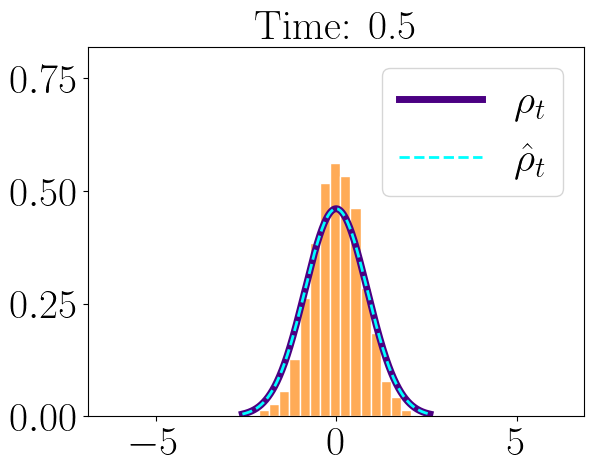

In [119]:
num_frames = len(all_steps)

# Create a figure
fig, ax = plt.subplots()

# Create the animation

animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB, all_steps, step_size, sigma_squared, True, 3*np.sqrt(sigma_squared + total_time), 0.82), interval=10)
animation.save(os.path.join(dir, f'eps{step_size}_time{total_time}.gif'), writer='imagemagick', fps=2)

# Show the animation
plt.show()
